# Install packages

In [2]:
%whos

Interactive namespace is empty.


In [3]:
%reset -f

In [4]:
!pip install transformers

In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds
from transformers import BertTokenizer

(ds_train, ds_test), ds_info = tfds.load('imdb_reviews',
          split = (tfds.Split.TRAIN, tfds.Split.TEST),
          as_supervised=True,
          with_info=True)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteUA8ZEF/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteUA8ZEF/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteUA8ZEF/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [6]:
def convert_example_to_feature(review):
  return tokenizer.encode_plus(review,
                add_special_tokens = True, # add [CLS], [SEP]
                max_length = max_length, # max length of the text that can go to BERT
                pad_to_max_length = True, # add [PAD] tokens
                return_attention_mask = True, # add attention mask to not focus on pad tokens
              )

def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

def encode_examples(ds, limit=-1):
  # prepare list, so that we can build up final TensorFlow dataset from slices.
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []
  if (limit > 0):
      ds = ds.take(limit)
  for review, label in tfds.as_numpy(ds):
    bert_input = convert_example_to_feature(review.decode())
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])
  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [7]:
# can be up to 512 for BERT
max_length = 512
batch_size = 4
print(max_length)

512


In [8]:
# train dataset
ds_train_encoded = encode_examples(ds_train).shuffle(10000).batch(batch_size)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [9]:
# test dataset
ds_test_encoded = encode_examples(ds_test).batch(batch_size)

In [10]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if "GPU" not in device_name:
    print("GPU device not found")

print('Found GPU at: {}'.format(device_name))

print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

Found GPU at: /device:GPU:0
GPU available (YESS!!!!)


In [11]:
from transformers import TFBertForSequenceClassification
# model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

In [12]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy

# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5
# we will do just 1 epoch, though multiple epochs might be better as long as we will not overfit the model
number_of_epochs = 1

# choosing Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metric = tf.keras.metrics.BinaryAccuracy('accuracy')

In [13]:
# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5

# we will do just 1 epoch, though multiple epochs might be better as long as we will not overfit the model
number_of_epochs = 1

# model initialization
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')
# choosing Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [16]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
bert_history_1 = model.fit(ds_train_encoded, epochs=1, validation_data=ds_test_encoded)

6250/6250 [==============================] - 4240s 672ms/step - loss: 0.2444 - accuracy: 0.9002 - val_loss: 0.1771 - val_accuracy: 0.9282


In [18]:
loss, accuracy = model.evaluate(ds_train_encoded)

print(f'Train Loss: {loss}')
print(f'Train Accuracy: {accuracy}')

6250/6250 [==============================] - 1092s 175ms/step - loss: 0.0993 - accuracy: 0.9672
Train Loss: 0.09934872388839722
Train Accuracy: 0.967199981212616


In [19]:
loss, accuracy = model.evaluate(ds_test_encoded)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

6250/6250 [==============================] - 1090s 174ms/step - loss: 0.1771 - accuracy: 0.9282
Test Loss: 0.17713837325572968
Test Accuracy: 0.9282400012016296


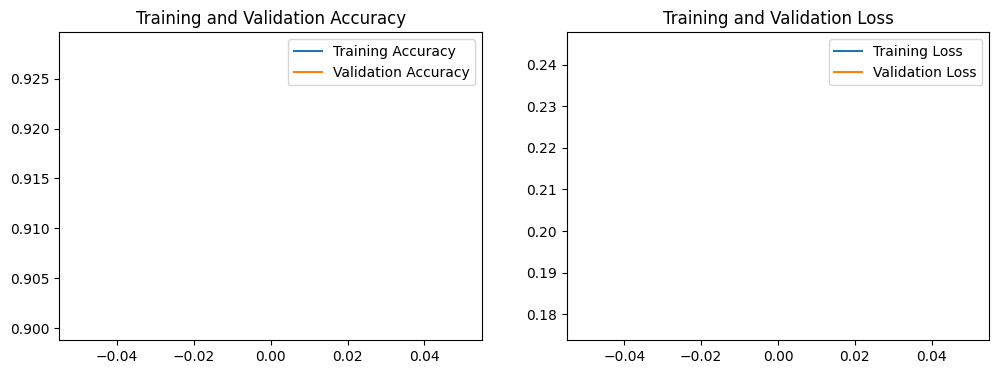

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(bert_history_1.history['accuracy'], label='Training Accuracy')
plt.plot(bert_history_1.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(bert_history_1.history['loss'], label='Training Loss')
plt.plot(bert_history_1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

In [29]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [30]:
from transformers import BertTokenizer

# Assuming you have trained a model with the variable name 'model'
model_save_path = '/home/Saved_BERT_model'
tokenizer_save_path = '/home/Saved_BERT_model'

# Save the model weights
model.save_pretrained(model_save_path)

# Save the tokenizer
tokenizer.save_pretrained(tokenizer_save_path)

('/content/gdrive/MyDrive/ColabNotebooks/IG2/Saved_BERT_model/tokenizer_config.json',
 '/content/gdrive/MyDrive/ColabNotebooks/IG2/Saved_BERT_model/special_tokens_map.json',
 '/content/gdrive/MyDrive/ColabNotebooks/IG2/Saved_BERT_model/vocab.txt',
 '/content/gdrive/MyDrive/ColabNotebooks/IG2/Saved_BERT_model/added_tokens.json')

In [32]:
import os
os.chdir(r'/home/Saved_BERT_model')

!tar -czf saved_bert_1.tar.gz .
#!tar -czf saved_bert_2.tar.gz saved_bert_2

from IPython.display import FileLink

FileLink(r'saved_bert_1.tar.gz')
#FileLink(r'saved_bert_2.tar.gz')

tar: ./saved_bert_1.tar.gz: file changed as we read it


/content/gdrive/MyDrive/ColabNotebooks/IG2/Saved_BERT_model/saved_bert_1.tar.gz

In [23]:
extra_single_sentences = [ ["Bad"],
  ["The attentive staff gave me excellent service."],
  ["The chef cooked us delicious food."],
  ["The messy room provided little comfort."],
  ["The unorganized event wasted my time."],
  ["The friendly staff offered helpful assistance."],
  ["Everything they did caused terrible inconvenience."],
  ["The customer-oriented team provided great service."],
  ["Their poor work left me highly disappointed."],
  ["This awful place will never get my business again."],
  ["The relaxing stay gave me a fantastic experience."],
  ["Their inefficient system cost me time and money."],
  ["Their high quality work left me very impressed."],
  ["The incompetent mechanics did a poor job on the repairs."],
  ["The unreliable company let me down when I needed them most."],
  ["Their amazing support team thrilled me."],
  ["This dreadful place should be avoided."],
  ["The skillful team nailed the job perfectly."],
  ["The undependable service provider could no longer be used."],
  ["They always exceeded my expectations with their work."],
  ["Using their services turned out to be a regrettable experience."],
  ["No complaints could be found with their wonderful services."],
  ["The disastrous event ruined my whole day."],
  ["Their surprise treats bring continuous delight."],
  ["The troublesome trip should be avoided at all costs."],
  ["Never once have they given me reason to complain."],
  ["The inefficient staff made everything so unnecessarily difficult."],
  ["Always an consistently 5-star experience with them."],
  ["Nothing but trouble seems to follow their shoddy work."],
  ["Their dependably brilliant work makes life easier."],
  ["The aggravating experience made it the worst time ever."]
]

extra_double_sentences = [ ["Good"],
  ["Although the food was delicious, the service was slow and unresponsive."],
  ["The hotel was clean and comfortable, but the staff was rude and unhelpful."],
  ["Despite the high prices, the quality of the products was excellent."],
  ["The customer service representative was friendly and knowledgeable, but the wait time on the phone was too long."],
  ["Although the location was convenient, the room was small and cramped."],
  ["The website was easy to navigate, but the checkout process was confusing and frustrating."],
  ["Despite the crowded atmosphere, the bartender was attentive and made great drinks."],
  ["The prices were reasonable, but the portion sizes were disappointingly small."],
  ["Although the store was busy, the sales associate was patient and helpful."],
  ["The spa was relaxing and rejuvenating, but the prices were a bit steep."],
  ["Despite the long wait time, the doctor was thorough and attentive during the appointment."],
  ["Although the delivery was fast, the food was cold and not as described."],
  ["The gym was well-equipped and clean, but the music was too loud and distracting."],
  ["Despite the limited menu options, the food was flavorful and well-prepared."],
  ["Although the staff was friendly, the hotel room was not as clean as expected."],
  ["The customer service was prompt and efficient, but the product was not as advertised."],
  ["Despite the high price tag, the quality of the service was worth it."],
  ["Although the restaurant was busy, the hostess was able to find us a table quickly."],
  ["The store had a great selection of products, but the checkout line was long and slow-moving."],
  ["Despite the inclement weather, the tour guide was knowledgeable and engaging."],
  ["Although the hotel was in a great location, the noise level was too high to get a good night's sleep."],
  ["The coffee shop had a cozy atmosphere, but the coffee itself was not very good."],
  ["Despite the friendly staff, the food took a long time to arrive at the table."],
  ["Although the website had a lot of information, it was difficult to find what I was looking for."],
  ["The customer service team was able to resolve my issue quickly, but the problem should not have occurred in the first place."],
  ["Despite the low prices, the quality of the products was surprisingly good."],
  ["Although the restaurant had a unique atmosphere, the food was not very flavorful."],
  ["The airline had comfortable seats and good in-flight entertainment, but the food was mediocre."],
  ["Despite the long wait time, the doctor was able to diagnose my condition accurately."],
  ["Although the hotel room was spacious, the air conditioning was not working properly."]
]

In [24]:
for i in extra_single_sentences:
    test_extra_sentence = i[0]
    predict_input = tokenizer.encode(test_extra_sentence,
                                     truncation=True,
                                     padding=True,
                                     return_tensors="tf")
    tf_output = model.predict(predict_input)[0]
    tf_prediction = tf.nn.softmax(tf_output, axis=1)
    labels = ['Negative','Positive'] #(0:negative, 1:positive)
    label = tf.argmax(tf_prediction, axis=1)
    label = label.numpy()
    percentage = round(100*tf_prediction.numpy()[0][1], 1)
    print(percentage, i[0])

1/1 [==============================] - 3s 3s/step
0.7 Bad
1/1 [==============================] - 3s 3s/step
96.1 The attentive staff gave me excellent service.
1/1 [==============================] - 0s 38ms/step
82.8 The chef cooked us delicious food.
1/1 [==============================] - 0s 36ms/step
1.5 The messy room provided little comfort.
1/1 [==============================] - 0s 40ms/step
0.4 The unorganized event wasted my time.
1/1 [==============================] - 0s 36ms/step
58.9 The friendly staff offered helpful assistance.
1/1 [==============================] - 0s 39ms/step
0.6 Everything they did caused terrible inconvenience.
1/1 [==============================] - 0s 49ms/step
95.2 The customer-oriented team provided great service.
1/1 [==============================] - 0s 48ms/step
0.4 Their poor work left me highly disappointed.
1/1 [==============================] - 0s 37ms/step
2.4 This awful place will never get my business again.
1/1 [==========================

In [25]:
for i in extra_double_sentences:
    test_extra_sentence = i[0]
    predict_input = tokenizer.encode(test_extra_sentence,
                                     truncation=True,
                                     padding=True,
                                     return_tensors="tf")
    tf_output = model.predict(predict_input)[0]
    tf_prediction = tf.nn.softmax(tf_output, axis=1)
    labels = ['Negative','Positive'] #(0:negative, 1:positive)
    label = tf.argmax(tf_prediction, axis=1)
    label = label.numpy()
    percentage = round(100*tf_prediction.numpy()[0][1], 1)
    print(percentage, i[0])

1/1 [==============================] - 0s 38ms/step
94.7 Good
1/1 [==============================] - 0s 40ms/step
4.0 Although the food was delicious, the service was slow and unresponsive.
1/1 [==============================] - 0s 40ms/step
5.9 The hotel was clean and comfortable, but the staff was rude and unhelpful.
1/1 [==============================] - 0s 47ms/step
96.6 Despite the high prices, the quality of the products was excellent.
1/1 [==============================] - 0s 41ms/step
17.7 The customer service representative was friendly and knowledgeable, but the wait time on the phone was too long.
1/1 [==============================] - 0s 37ms/step
5.4 Although the location was convenient, the room was small and cramped.
1/1 [==============================] - 0s 42ms/step
3.9 The website was easy to navigate, but the checkout process was confusing and frustrating.
1/1 [==============================] - 0s 39ms/step
95.6 Despite the crowded atmosphere, the bartender was atten